In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt
import multiprocessing


import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim

In [ ]:
import cv2

In [52]:
class FaceDetection():
    
    def __init__(self, path2img = 'figures/fig.jpg', path2class = '/Users/renatobottermaiolopesrodrigues/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml'):
        
        #Load image
        self.img_original = cv2.imread(path2img)
        
        # Convert to RGB colorspace
        self.img_original = self.convertToRGB(self.img_original)
        
        # copy original image
        self.img_with_detections = np.copy(self.img_original)
        
        #convert image to gray (opencv expects gray images)
        self.gray_img = self.convertToGray(self.img_original)

        #load cascade classifier (haarcascade) training file
        self.haar_face_cascade = cv2.CascadeClassifier(path2class)

        #Detect multiscale images 
        self.faces = self.haar_face_cascade.detectMultiScale(self.gray_img, scaleFactor=1.1, minNeighbors=5);

    def number_faces(self):
        #print the number of faces found 
        print('Faces found: ', len(self.faces))

    def convertToGray(self, img):
        # Convert the RGB  image to grayscale
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    def convertToRGB(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    def detection(self):
    
        faces_crop = []
        for (x, y, w, h) in self.faces:  
            obj = self.img_with_detections[y:y + h, x:x + w]
            faces_crop.append(obj)
            cv2.rectangle(self.img_with_detections, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
        return faces_crop

In [53]:
FaceDetection = FaceDetection()

In [54]:
FaceDetection.number_faces()

Faces found:  9


In [55]:
faces_crop = FaceDetection.detection()
(img_original, img_with_detections) =  (FaceDetection.img_original, FaceDetection.img_with_detections)

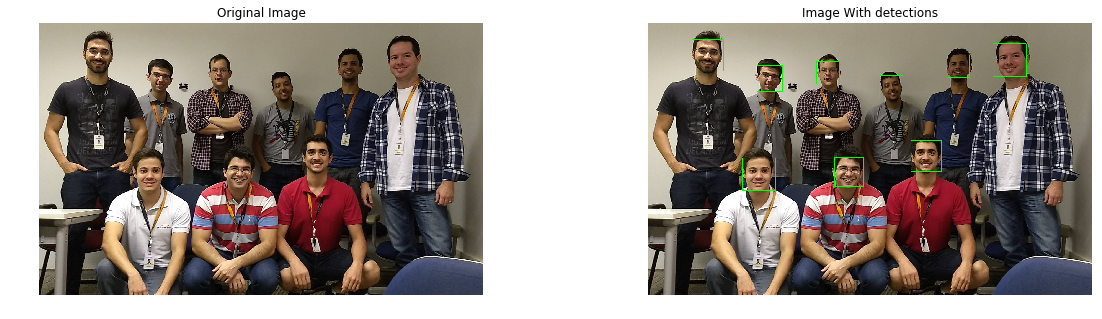

In [56]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(img_original)
plt.title('Original Image')
plt.axis('off')


plt.subplot(1,2,2)
#convert image to RGB and show image 
plt.imshow(img_with_detections)
plt.title('Image With detections')
plt.axis('off')

fig.savefig('figures/fig_detection.png')

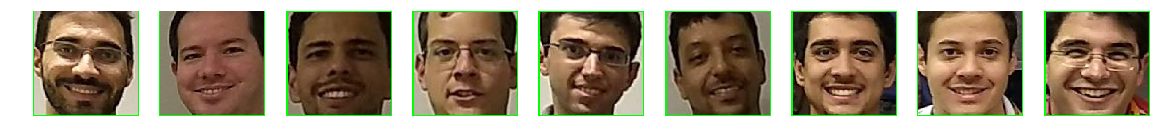

In [57]:
plt.figure(figsize=(20,5))
count = 1
for face in faces_crop:
    plt.subplot(1,len(faces_crop),count)
    count+=1
    plt.imshow(face)
    plt.axis('off')

In [2]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)
cpu_count = multiprocessing.cpu_count()
print('cpu_count: ', cpu_count)

GPU available: False
cpu_count:  12


In [3]:
path2data = '/home/r120084/data/'

In [4]:
path2trainData = path2data + 'train/training.csv'
path2testData = path2data + 'test/test.csv'

In [5]:
batch_size = 32

In [6]:
class FaceKeyPointsDataset(Dataset):

    def __init__(self, path2data, val_size = 0.1, dropnan = True, transforms=None,
                 is_valid=False, is_test=False, is_train = False):
        
        
        self.transform = transforms    
        df = pd.read_csv(path2data)
        self.get_columns(df)
        
        if dropnan:
            df = df.dropna()
            
        df['Image'] = df['Image'].apply(lambda img:  np.fromstring(img, sep = ' '))
        self.X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
        self.X = self.X.astype(np.float32)
        self.X = self.X.reshape(-1, 1, 96, 96) # return each images as 1 x 96 x 96
        
        
        if ( (is_train) or (is_valid)):
            self.y = df[df.columns[:-1]].values

            if is_valid:
                self.split_data(val_size)
                
            self.y = (self.y - 48) / 48 
            self.y = self.y.astype(np.float32)

        if is_test:
            self.y = np.zeros([len(df), len(df.columns[:-1])])

    def get_columns(self, df):
        self.columns = df.columns
                 
    def split_data(self, val_size = 0.1):

        np.random.seed(4572)
        indices = range(len(self.X))

        ind = np.random.permutation(indices)
        split = np.round(val_size * len(self.X))
        index= np.array(ind[:split])
        
        self.X = self.X.take(index,axis=0)
        self.y = self.y.take(index,axis=0)
    
    def __getitem__(self, index):
        image = self.X[index]
        keypoints = self.y[index]        
        sample = {'input': image, 'output': keypoints}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

    # documentar no pytorch
    def __len__(self):
        return len(self.X)

In [7]:
class ToTensor(object):

    def __call__(self, sample):
        image, keypoints = sample['input'], sample['output']

        # imagem numpy: C x H x W
        # imagem torch: C X H X W
                    
        image = image.transpose((0, 1, 2))
        return {'input': torch.from_numpy(image),
                'output': torch.from_numpy(keypoints)}

In [8]:
class CloneArray(object):
    
    def __call__(self, sample):
        image, keypoints = sample['input'], sample['output']

        image = image.repeat(3, axis=0)
        return {'input': image,
                'output': keypoints}

In [9]:
data_transforms = {
    'train': transforms.Compose([
        CloneArray(),
        ToTensor()

    ]),
    'valid': transforms.Compose([
        CloneArray(),
        ToTensor()
    ]),
}

In [10]:
dsets = {
    'train': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['train'], is_train = True),
    'valid': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['valid'], is_valid=True),
    'test':  FaceKeyPointsDataset(path2testData, transforms=data_transforms['valid'], is_test=True),
}

/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
def _create_dataLoader(dsets, batch_size, cpu_count, pin_memory =  False):

    dset_loaders = {}
    for key in dsets.keys():
        if key == 'train':
            shuffle = True
        else:
            shuffle = False
        dset_loaders[key] = DataLoader(dsets[key], batch_size=batch_size, num_workers=2*cpu_count, shuffle=shuffle, pin_memory=pin_memory)

    return dset_loaders

In [12]:
dset_loaders = _create_dataLoader(dsets, batch_size, cpu_count)

In [13]:
sample_train = next(iter(dset_loaders['train']))
print(sample_train['input'].size(), sample_train['output'].size())

torch.Size([32, 3, 96, 96]) torch.Size([32, 30])


In [18]:
def plot_face_Keypoints(dsets, is_train = True, preds_test = [], preds_train = []):
    
    plt.figure(figsize=(20,10))
    for i in range(0, 8):
        plt.subplot(2,4,i+1)

        rand_img = random.randrange(0, len(dsets))

        X = dsets[rand_img]['input'].numpy()
        img = X.transpose((1, 2, 0))
        img = np.squeeze(img)

        if is_train:
            y =  dsets[rand_img]['output'].numpy()
        else:
            y = preds_test.numpy()[rand_img]

        cordinates = y * 48 + 48

        plt.imshow(img, cmap = 'gray')
        if (len(preds_train) !=0):
            plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
            y_train = preds_train.numpy()
            cordinates_train = y_train[rand_img]*48 + 48
            plt.scatter(cordinates_train[::2], cordinates_train[1::2], marker='o', c='r', s=10)

        plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
        plt.title('Sample n {}'.format(rand_img))
        plt.axis('off')

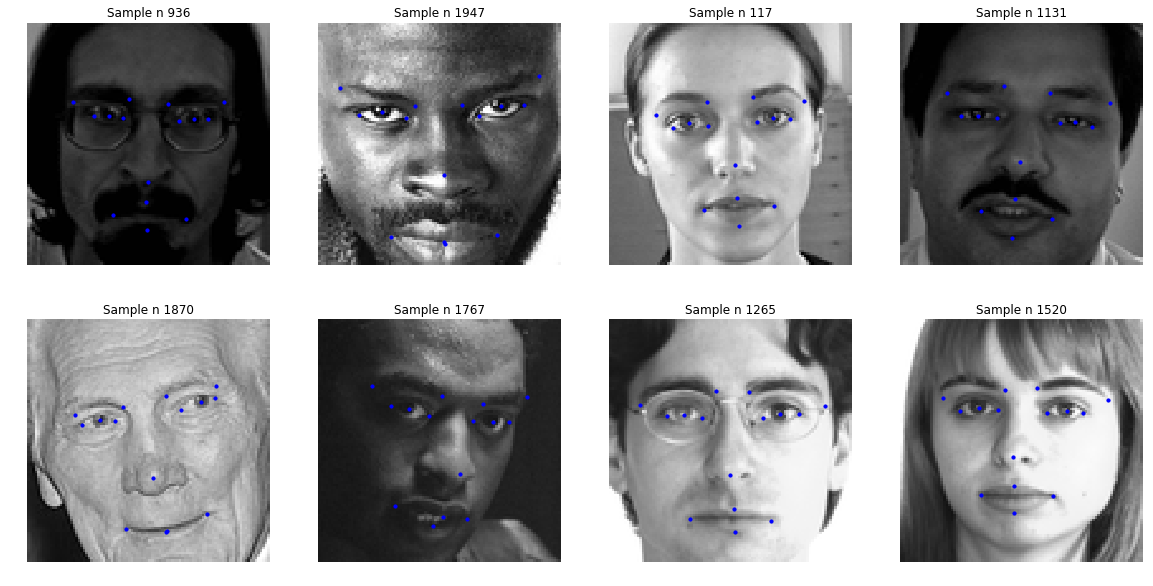

In [19]:
plot_face_Keypoints(dsets['train'])

In [17]:
nb_out = 30

In [100]:
class MyResnet18(torch.nn.Module):
    def __init__(self, fixed_feature=True):
        super(MyResnet18, self).__init__()
        self.my_resnet18_model = models.resnet18(pretrained=True)
        
        del self.my_resnet18_model.layer2
        del self.my_resnet18_model.layer3
        del self.my_resnet18_model.layer4
        
        if(fixed_feature):
            for param in self.my_resnet18_model.parameters():
                param.requires_grad = False
        
        self.my_resnet18_model.fc = torch.nn.Sequential(torch.nn.Linear(576, 128),
                                                        torch.nn.ReLU(inplace=True),
                                                        torch.nn.Linear(128, 64),
                                                        torch.nn.ReLU(inplace=True),
                                                        torch.nn.Linear(64, 30))

    def forward(self, x):

        x = self.my_resnet18_model.conv1(x)
        x = self.my_resnet18_model.bn1(x)
        x = self.my_resnet18_model.relu(x)
        x = self.my_resnet18_model.maxpool(x)
        x = self.my_resnet18_model.layer1(x)        
        x = self.my_resnet18_model.avgpool(x)
        
        x = x.view(x.size(0), -1)
        x = self.my_resnet18_model.fc(x)
        return x

In [101]:
model = MyResnet18()
if use_gpu:
    model.cuda() 

In [102]:
print(model)

MyResnet18 (
  (my_resnet18_model): ResNet (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3

In [104]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, (data) in enumerate(loader):     
        inputs, labels = data['input'], data['output']
        #inputs, labels = data


        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.data[0]
            
    return (total_loss / i)

In [140]:
def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    history_loss = []
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    patience_count= 0
    ii_n = len(train_loader)
    for epoch in range(num_epochs):
        for i, (data) in enumerate(train_loader):
            
            print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
            inputs, labels = data['input'], data['output']
            #inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            predict = model(inputs)
            
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(loss.data[0])
        loss_test.append( evaluate_model(test_loader, model,loss_fn) )
        history_loss.append(loss.data[0])
        
        print('\nEpoch: {}  Loss Train: {}  Lost Test: {}'.format(epoch, loss_train[-1], loss_test[-1]), end='\n')
        #Early stopping
        if(best_test_acc < loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('\rDone!')
    return history_loss, loss_train, loss_train, model 

In [144]:
loss_fn = torch.nn.MSELoss()
optimizer =  optim.RMSprop(model.my_resnet18_model.fc.parameters(), lr=1e-3)
num_epochs = 5
patience = 2

In [145]:
params = {'model' : model, 
        'train_loader':dset_loaders['train'],
         'test_loader':dset_loaders['valid'],
         'num_epochs': num_epochs,
         'loss_fn': loss_fn,
        'optimizer': optimizer, 
         'patience': patience 
         }

In [147]:
history_loss, loss_train, loss_train, model   = train(**params)

predict: 66/66
Epoch: 0  Loss Train: 0.0037500399630516768  Lost Test: 0.004430091513010363
predict: 66/66
Epoch: 1  Loss Train: 0.004305414855480194  Lost Test: 0.004897633955503504
predict: 66/66
Epoch: 2  Loss Train: 0.00268298271112144  Lost Test: 0.004478593240492046
predict: 66/66
Epoch: 3  Loss Train: 0.0036338497884571552  Lost Test: 0.004062556894496083
Done!


In [148]:
def predict(model, dset_loaders, use_gpu = False):

    predictions = []
    if use_gpu:
        use_gpu = torch.cuda.is_available()

    model.train(False)  # Set model to evaluate mode
    ii_n = len(dset_loaders)
    for ii, data in enumerate(dset_loaders):
        try:
            image, labels = data['input'], data['output']
        except:
            image, labels = data

        if use_gpu:
            image = Variable(image.cuda())
        else:
            image = Variable(image)
        outputs = model(image)
        predictions.append(outputs.data.cpu())
        print('\rpredict: {}/{}'.format(ii, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return torch.cat(predictions, 0)

In [149]:
preds_test = predict(model, dset_loaders['test'])
preds_train = predict(model, dset_loaders['train'])

predict: 55/55 ok
predict: 66/66 ok


In [150]:
(preds_test.shape, preds_train.shape)

(torch.Size([1783, 30]), torch.Size([2140, 30]))

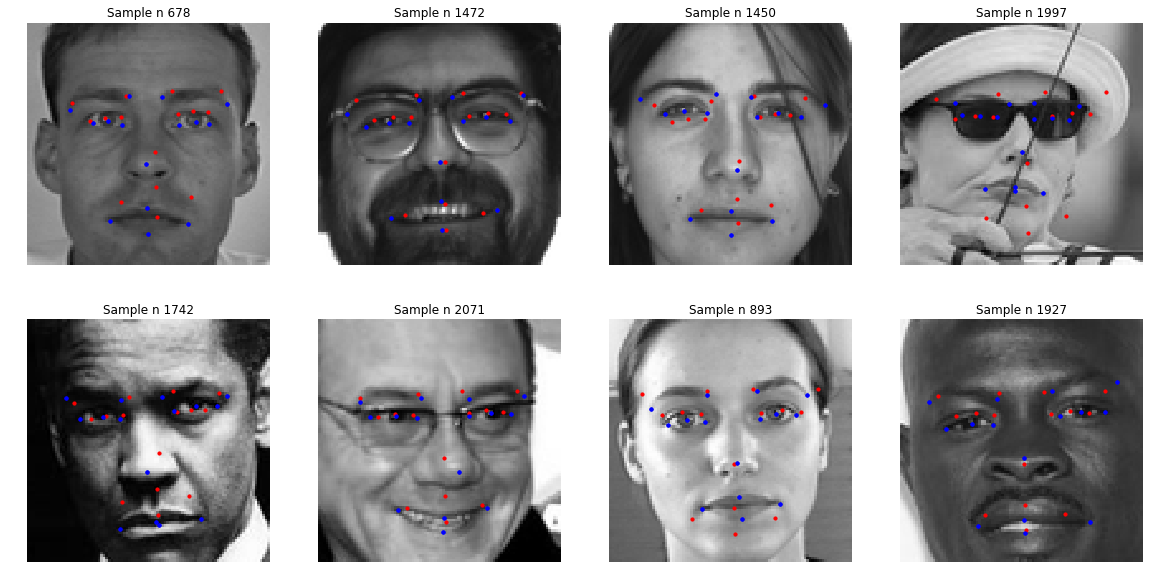

In [151]:
plot_face_Keypoints(dsets['train'],  preds_train = preds_train)

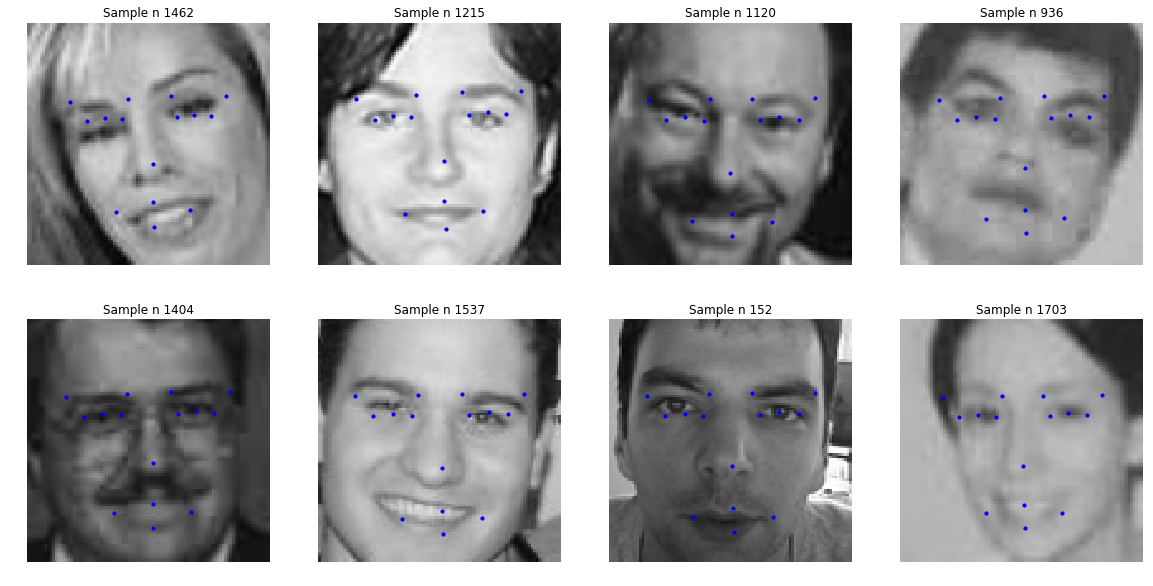

In [152]:
plot_face_Keypoints(dsets['test'], is_train= False,  preds_test = preds_test)

In [26]:
id_lookup_frame = pd.read_csv(path2data + "IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [50]:
y_test= preds_test.numpy() * 48  + 48
columns = dsets['train'].columns[:-1]

In [ ]:
def generate_output_submission(y_test, columns, filename = "result.csv"):
    y_res = []
    j = 0
    k = 0
    m = 0
    for i in range(1, len(y_test)+1):
        img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
        if img.shape[0] == 30:
            y_res += list(y_test[i-1,:])
            j += 30
        else:
            slice_img = y_test[i-1, :]
            y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
            k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
    y_res = np.array(y_res)

    
    result_dict = {
    "RowId": range(1,y_res.shape[0]+1),
    "Location": y_res
    }
    result_df = pd.DataFrame(result_dict, )
    result_df.to_csv(filename, index=False, columns=["RowId", "Location"])
    print('Done!')

In [ ]:
generate_output_submission(y_test, columns)

In [ ]:
print('Done!')